Mounted at /content/drive
Found 1081 real images.
Found 960 fake images.
Copying training data...
Copying validation data...
Copying test data...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


Dataset preparation complete.


100%|██████████| 13.6M/13.6M [00:00<00:00, 189MB/s]


Starting training...


<ipython-input-1-ee233eec4daf>:139: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
<ipython-input-1-ee233eec4daf>:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/10, Train Loss: 0.6792, Validation Loss: 0.6595, Validation Accuracy: 0.65
Epoch 2/10, Train Loss: 0.5655, Validation Loss: 0.6111, Validation Accuracy: 0.70
Epoch 3/10, Train Loss: 0.4290, Validation Loss: 0.5921, Validation Accuracy: 0.71
Epoch 4/10, Train Loss: 0.2691, Validation Loss: 0.5969, Validation Accuracy: 0.74
Epoch 5/10, Train Loss: 0.1383, Validation Loss: 0.6716, Validation Accuracy: 0.69
Epoch 6/10, Train Loss: 0.0508, Validation Loss: 0.7132, Validation Accuracy: 0.69
Epoch 7/10, Train Loss: 0.0279, Validation Loss: 0.7701, Validation Accuracy: 0.70
Epoch 8/10, Train Loss: 0.0150, Validation Loss: 0.8486, Validation Accuracy: 0.71
Epoch 9/10, Train Loss: 0.0097, Validation Loss: 0.8578, Validation Accuracy: 0.70
Epoch 10/10, Train Loss: 0.0099, Validation Loss: 0.9221, Validation Accuracy: 0.69


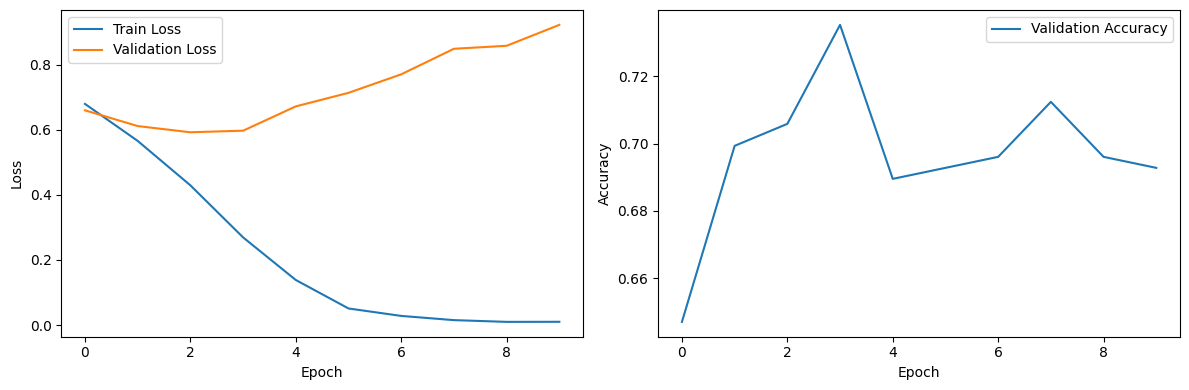

Training complete!

Evaluating model...

Computing class-wise losses...
Average Loss (Real (Class 0)): 0.5052
Average Loss (Fake (Class 1)): 0.5452

Overall Metrics:
Accuracy: 0.7622
Precision: 0.7413
Recall: 0.7465
F1 Score: 0.7439

Classification Report:
              precision    recall  f1-score   support

        Real       0.78      0.78      0.78       165
        Fake       0.74      0.75      0.74       142

    accuracy                           0.76       307
   macro avg       0.76      0.76      0.76       307
weighted avg       0.76      0.76      0.76       307


Confusion Matrix:
[[128  37]
 [ 36 106]]


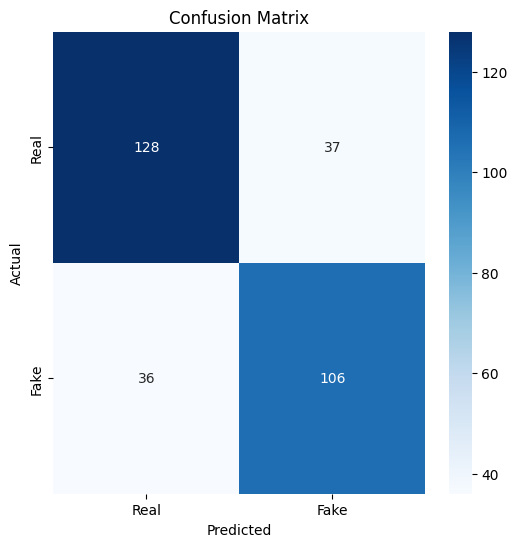

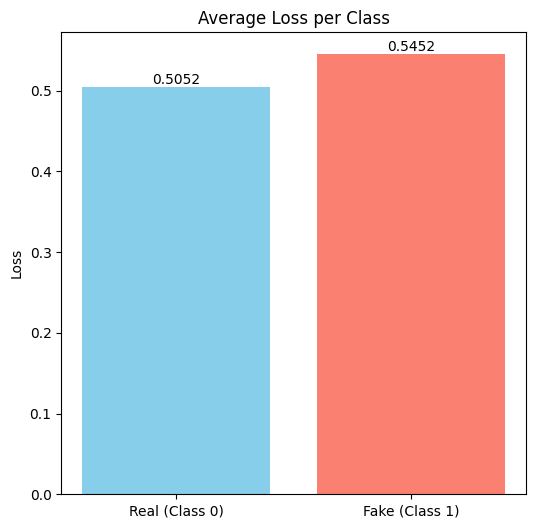


Final Results:
Real Class Loss (s0): 0.5052
Fake Class Loss (s1): 0.5452
Accuracy: 0.7622
Precision: 0.7413
Recall: 0.7465
F1 Score: 0.7439


In [ ]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import os
import cv2
import numpy as np
import shutil
from concurrent.futures import ThreadPoolExecutor
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns

# Mount Google Drive
drive.mount('/content/drive')

# Define paths
image_real_path = "/content/drive/MyDrive/Data/raw_images/real"
image_fake_path = "/content/drive/MyDrive/Data/raw_images/fake"

train_dir = "/content/drive/MyDrive/Data/image_dataset/train"
val_dir = "/content/drive/MyDrive/Data/image_dataset/validation"
test_dir = "/content/drive/MyDrive/Data/image_dataset/test"

# Create directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Function to copy files in parallel
def copy_files_parallel(paths, labels, destination_folder):
    def copy_file(path, dest):
        if not os.path.exists(dest):
            os.makedirs(os.path.dirname(dest), exist_ok=True)
            shutil.copy(path, dest)

    with ThreadPoolExecutor() as executor:
        futures = []
        for path, label in zip(paths, labels):
            label_folder = "real" if label == 0 else "fake"
            dest = os.path.join(destination_folder, label_folder, os.path.basename(path))
            futures.append(executor.submit(copy_file, path, dest))

        for future in futures:
            future.result()

# Prepare dataset
real_images = [(os.path.join(image_real_path, img), 0) for img in os.listdir(image_real_path) if img.endswith(('.png', '.jpg', '.jpeg'))]
fake_images = [(os.path.join(image_fake_path, img), 1) for img in os.listdir(image_fake_path) if img.endswith(('.png', '.jpg', '.jpeg'))]

print(f"Found {len(real_images)} real images.")
print(f"Found {len(fake_images)} fake images.")

all_images = real_images + fake_images

if not all_images:
    raise ValueError("No images found in the dataset folders!")

paths, labels = zip(*all_images)

# Split dataset
train_paths, temp_paths, train_labels, temp_labels = train_test_split(paths, labels, test_size=0.3, random_state=42)
val_paths, test_paths, val_labels, test_labels = train_test_split(temp_paths, temp_labels, test_size=0.5, random_state=42)

# Copy files to respective directories
print("Copying training data...")
copy_files_parallel(train_paths, train_labels, train_dir)

print("Copying validation data...")
copy_files_parallel(val_paths, val_labels, val_dir)

print("Copying test data...")
copy_files_parallel(test_paths, test_labels, test_dir)

print("Dataset preparation complete.")

# Custom Dataset Class
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path)
        if image is None:
            print(f"Warning: Could not read image {image_path}")
            return self.__getitem__((idx + 1) % len(self))

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

# Data transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets and data loaders
train_dataset = CustomImageDataset(train_paths, train_labels, transform=transform)
val_dataset = CustomImageDataset(val_paths, val_labels, transform=transform)
test_dataset = CustomImageDataset(test_paths, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Model Definition
class ModifiedMobileNetV2(nn.Module):
    def __init__(self):
        super(ModifiedMobileNetV2, self).__init__()
        self.model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, 2)

    def forward(self, x):
        return self.model(x)

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ModifiedMobileNetV2().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scaler = torch.cuda.amp.GradScaler()

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()

        # Calculate validation metrics
        val_loss = 0.0
        correct = 0
        total = 0
        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Store metrics for plotting
        train_loss = running_loss/len(train_loader)
        val_loss /= len(val_loader)
        val_acc = correct / total

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, "
              f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "/content/drive/MyDrive/Data/image_classification_model.pth")

    # Plot training curves
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Train the model
print("Starting training...")
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)
print("Training complete!")

# Function to plot class losses
def plot_class_losses(s0, s1):
    classes = ['Real (Class 0)', 'Fake (Class 1)']
    losses = [s0, s1]

    plt.figure(figsize=(6, 6))
    bars = plt.bar(classes, losses, color=['skyblue', 'salmon'])
    plt.title('Average Loss per Class')
    plt.ylabel('Loss')

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', ha='center', va='bottom')

    plt.show()

# Enhanced evaluation function with class-wise metrics
def evaluate_model_with_class_scores(model, test_loader, criterion):
    model.load_state_dict(torch.load("/content/drive/MyDrive/Data/image_classification_model.pth"))
    model.eval()

    # Separate real and fake samples
    real_inputs = []
    real_labels = []
    fake_inputs = []
    fake_labels = []

    # Collect all samples
    for inputs, labels in test_loader:
        for i in range(len(labels)):
            if labels[i] == 0:
                real_inputs.append(inputs[i])
                real_labels.append(labels[i])
            else:
                fake_inputs.append(inputs[i])
                fake_labels.append(labels[i])

    # Compute average loss for a class
    def compute_avg_loss(inputs_list, labels_list, label_name="Class"):
        total_loss = 0.0
        total_samples = 0
        batch_size = 32

        for i in range(0, len(inputs_list), batch_size):
            batch_inputs = torch.stack(inputs_list[i:i + batch_size]).to(device)
            batch_labels = torch.tensor(labels_list[i:i + batch_size]).to(device)

            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_labels)

            total_loss += loss.item() * batch_inputs.size(0)
            total_samples += batch_inputs.size(0)

        avg_loss = total_loss / total_samples
        print(f"Average Loss ({label_name}): {avg_loss:.4f}")
        return avg_loss

    print("\nComputing class-wise losses...")
    s0 = compute_avg_loss(real_inputs, real_labels, label_name="Real (Class 0)")
    s1 = compute_avg_loss(fake_inputs, fake_labels, label_name="Fake (Class 1)")

    # Compute overall metrics
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=["Real", "Fake"])
    cm = confusion_matrix(all_labels, all_preds)

    print("\nOverall Metrics:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:")
    print(report)
    print("\nConfusion Matrix:")
    print(cm)

    # Plot confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # Plot class losses
    plot_class_losses(s0, s1)

    return s0, s1, acc, precision, recall, f1

# Evaluate the model
print("\nEvaluating model...")
s0, s1, acc, precision, recall, f1 = evaluate_model_with_class_scores(model, test_loader, criterion)

print("\nFinal Results:")
print(f"Real Class Loss (s0): {s0:.4f}")
print(f"Fake Class Loss (s1): {s1:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Saving real_00017.jpg to real_00017.jpg


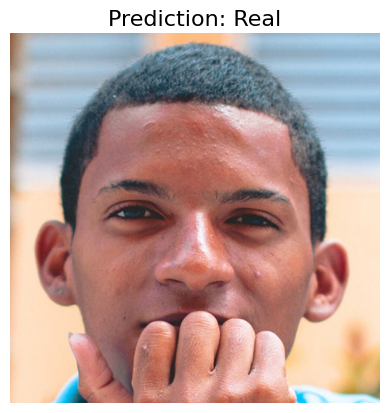

In [ ]:
#APPLICATION TO CHECK
from google.colab import files
from PIL import Image
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import matplotlib.pyplot as plt
from google.colab import drive
#drive.mount('/content/drive')
# Upload image
uploaded = files.upload()
image_path = next(iter(uploaded))

# Define preprocessing transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and preprocess the image
image = Image.open(image_path).convert('RGB')
input_tensor = transform(image).unsqueeze(0)

# Load the trained model
class ModifiedMobileNetV2(nn.Module):
    def __init__(self):
        super(ModifiedMobileNetV2, self).__init__()
        self.model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, 2)

    def forward(self, x):
        return self.model(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ModifiedMobileNetV2().to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/Data/image_classification_model.pth", map_location=device))
model.eval()

# Run inference
with torch.no_grad():
    input_tensor = input_tensor.to(device)
    output = model(input_tensor)
    _, predicted = torch.max(output, 1)

# Map prediction to label
class_names = ["Real", "Fake"]
prediction = class_names[predicted.item()]

# Display the image and prediction
plt.imshow(image)
plt.title(f"Prediction: {prediction}", fontsize=16)
plt.axis('off')
plt.show()
